In [25]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing

import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [26]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

In [27]:
import random
random.seed(42)

## Download Data

In [28]:
dset = fetch_california_housing()

In [29]:
data = dset['data']
y = dset['target']
LABEL = dset['target_names'][0]

NUMERIC_FEATURES = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude', 'Latitude']

data = pd.DataFrame(data, columns=dset['feature_names'])
data[LABEL] = y

In [30]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [31]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")


Train dataset shape: (16512, 9)
Test dataset shape: (4128, 9)


## Data Processing

In [32]:
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [33]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [34]:
FEATURES = NUMERIC_FEATURES

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10584\141569203.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[LABEL])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10584\141569203.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_val[LABEL])
C:\Users\Lenovo\AppData\Local\Temp\ipyke

<Axes: xlabel='MedHouseVal', ylabel='Density'>

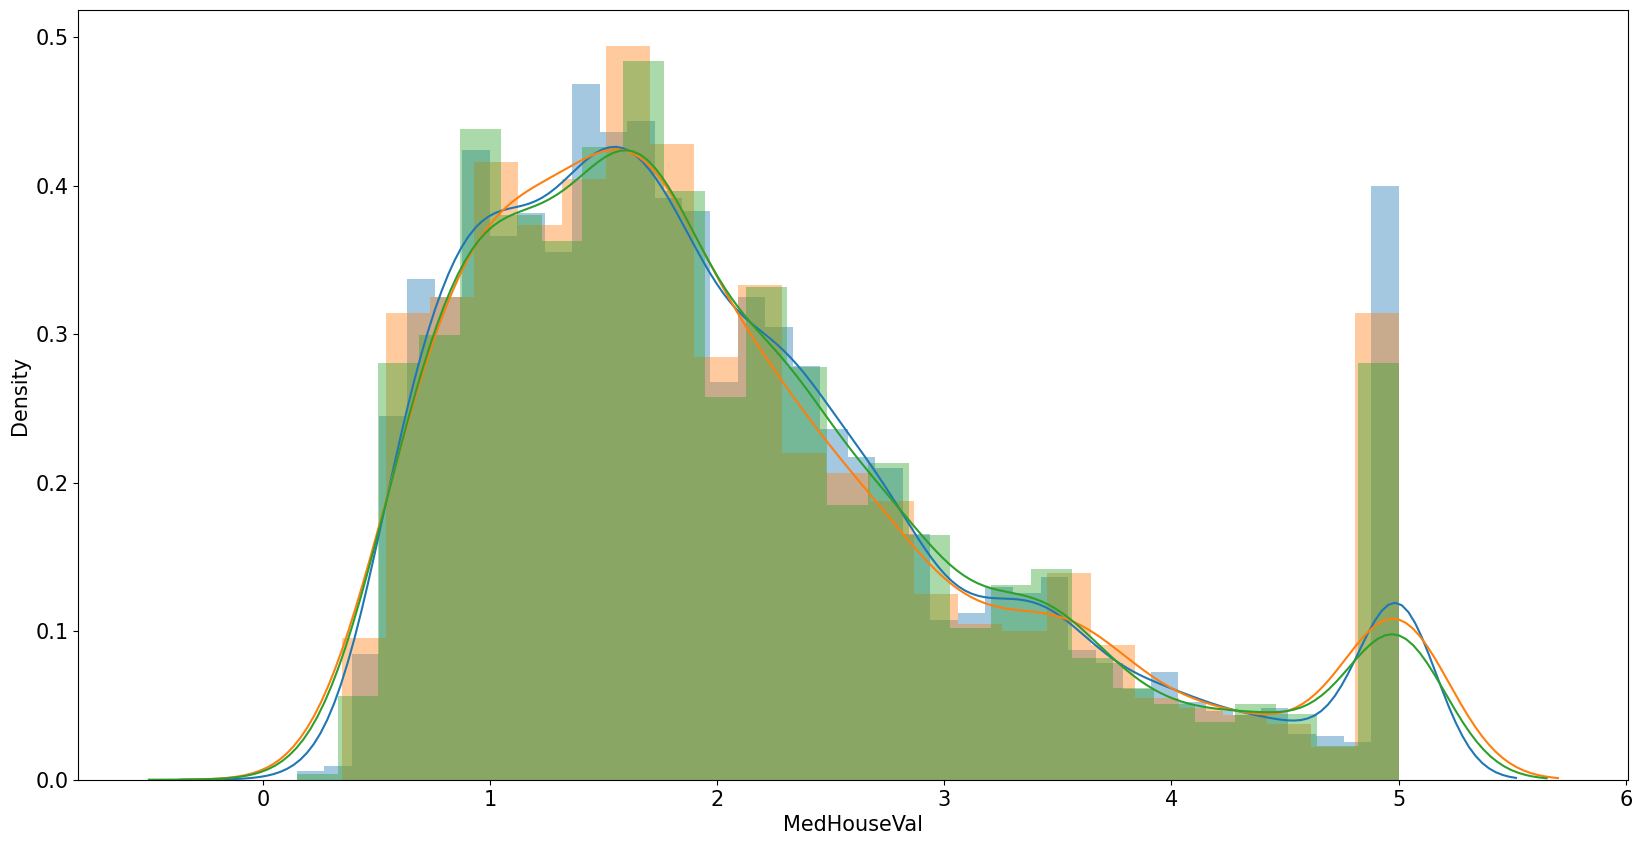

In [35]:
sns.distplot(X_train[LABEL])
sns.distplot(X_val[LABEL])
sns.distplot(test_data[LABEL])

# Baselines

In [36]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20)
rf.fit(X_train[FEATURES], X_train[LABEL])

RandomForestRegressor(max_depth=20)

In [37]:
rf_preds = rf.predict(test_data[FEATURES])
rf_rms = mean_squared_error(test_data[LABEL], rf_preds, squared=False)
print(rf_rms)

0.5119299239493756


## CatBoost

In [38]:
catb_train_dataset = cb.Pool(X_train[FEATURES], X_train[LABEL]) 
catb_val_dataset = cb.Pool(X_val[FEATURES], X_val[LABEL]) 
catb_test_dataset = cb.Pool(test_data[FEATURES], test_data[LABEL])

In [39]:
tuned_catb = cb.CatBoostRegressor()
tuned_catb.fit(catb_train_dataset, eval_set=catb_val_dataset, early_stopping_rounds=50)

Learning rate set to 0.076361
0:	learn: 1.1008347	test: 1.1331484	best: 1.1331484 (0)	total: 5.03ms	remaining: 5.03s
1:	learn: 1.0579300	test: 1.0901279	best: 1.0901279 (1)	total: 8.69ms	remaining: 4.34s
2:	learn: 1.0188672	test: 1.0514373	best: 1.0514373 (2)	total: 12.4ms	remaining: 4.11s
3:	learn: 0.9830148	test: 1.0155434	best: 1.0155434 (3)	total: 15.3ms	remaining: 3.82s
4:	learn: 0.9505341	test: 0.9822388	best: 0.9822388 (4)	total: 18ms	remaining: 3.58s
5:	learn: 0.9205209	test: 0.9523724	best: 0.9523724 (5)	total: 20.4ms	remaining: 3.37s
6:	learn: 0.8941091	test: 0.9259098	best: 0.9259098 (6)	total: 23.7ms	remaining: 3.36s
7:	learn: 0.8679410	test: 0.8999919	best: 0.8999919 (7)	total: 26.3ms	remaining: 3.27s
8:	learn: 0.8442732	test: 0.8766492	best: 0.8766492 (8)	total: 28.9ms	remaining: 3.18s
9:	learn: 0.8219843	test: 0.8541320	best: 0.8541320 (9)	total: 31.4ms	remaining: 3.11s
10:	learn: 0.8024527	test: 0.8345876	best: 0.8345876 (10)	total: 34.1ms	remaining: 3.06s
11:	learn: 0.

In [40]:
catb_preds = tuned_catb.predict(catb_test_dataset)

In [41]:
catb_rms = mean_squared_error(test_data[LABEL], catb_preds, squared=False)